In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["font.family"] = "Arial"

from scipy.io import savemat, loadmat
from scipy.ndimage import gaussian_filter1d as gf1d
import colorsys

In [2]:
# %matplotlib widget 

## Load data

In [3]:
def RBF(d,lmbda):
    return np.exp(-d**2/2/lmbda**2)

def mldivide(A,B):
    return np.linalg.pinv(A).dot(B)
    
def sm_GP(qq,f,lmbda,sigma):
    d_ij = qq.reshape(len(qq),1) - qq.reshape(1,len(qq))
    
    K = RBF(d_ij,lmbda)
    K_s = K
    K_y = K + np.eye(len(qq))*sigma**2
    
    y = f
    L = np.linalg.cholesky(K_y)

    alpha = mldivide(L.T,mldivide(L,y))
    E = K_s.T@alpha
    
    return E

In [4]:
#### Meshgrid ####
n_grid = 100
x = np.linspace(-1,1,n_grid+1)
y = np.linspace(-1,1,n_grid+1)
z = np.linspace(-1,1,n_grid+1)

r_grid = np.meshgrid(x,y,z) 

# calculate scattering function
box_size = 2
n_grid_scale = 256
scale = n_grid_scale/r_grid[0].shape[0]
dq = 2*np.pi/box_size
qq = np.arange(n_grid_scale/2)*dq

#################################
S_q_Grid = []
p_Grid = []
for i in range(10):
    #### load data ####
    filename = './training_set/alpha/grid/S_q_{}.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

for i in range(10):
    #### load data ####
    filename = './training_set/alpha/grid/S_q_{}.5.mat'.format(i)
    data = loadmat(filename)
    k_grid = data['k_grid']
    S_q_kxy = data['S_q_kxy']
    
    S_q_Grid.append(S_q_kxy)
    p_Grid.append(k_grid)

S_q_Grid = np.array(S_q_Grid).reshape(2000,128)[:,1:]
p_Grid = np.array(p_Grid).reshape(2000,3)
S_q_sm_Grid = np.exp(np.array([gf1d(f,1,mode='nearest') for f in np.log(S_q_Grid)]))

k_z = p_Grid[:,0]
alpha = p_Grid[:,1]
kappa = p_Grid[:,2]
set_k_z = np.unique(k_z)
set_alpha = np.unique(alpha)
set_kappa = np.flip(np.unique(kappa))

print('\nk_z in')
print(set_k_z)
print('\nalpha in')
print(set_alpha)
print('\nkappa in')
print(set_kappa)


k_z in
[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]

alpha in
[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45]

kappa in
[128.          90.50966799  64.          45.254834    32.
  22.627417    16.          11.3137085    8.           5.65685425
   4.           2.82842712   2.           1.41421356   1.
   0.70710678   0.5          0.35355339   0.25         0.1767767 ]


In [183]:
# indexing
def id_params(parameters):
    tol = 1e-6
    id_k_z = np.abs(k_z-parameters[0])<tol
    id_alpha = np.abs(alpha-parameters[1])<tol
    id_kappa = np.abs(kappa-parameters[2])<tol
    return np.where(id_k_z*id_alpha*id_kappa)[0][0]

# color
def color_params(parameters):
    k_z_reduced = (parameters[0]-1)/10
    alpha_reduced = parameters[1]/0.5
    kappa_reduced = np.log(parameters[2])/10
    return [k_z_reduced, kappa_reduced, alpha_reduced]

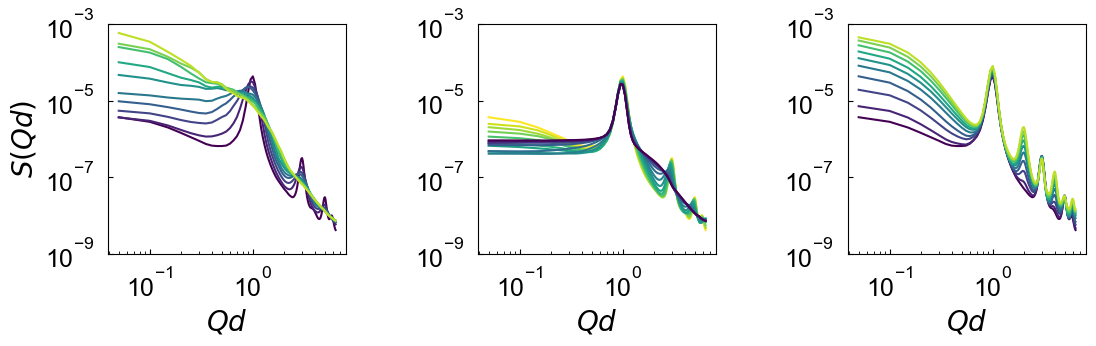

In [192]:
## plot results: varying k_z
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(1,3,1)

for i, k_z_i in enumerate(set_k_z):
    parameters = [k_z_i,set_alpha[0],set_kappa[0]]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(i/10)

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.7)
ax = fig.add_subplot(1,3,2)

for i, kappa_i in enumerate(set_kappa[:15]):
    parameters = [set_k_z[0],set_alpha[0],kappa_i]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(np.log(kappa_i)/np.log(128))  

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
# ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.7)
ax = fig.add_subplot(1,3,3)

for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[0],alpha_i,set_kappa[0]]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(i/10)

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
# ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.7)

plt.tight_layout(pad=4)
plt.show()

## SVD

In [10]:
zscore = lambda X: np.array([(x-np.mean(x))/np.std(x) for x in X])
f_F = lambda x: np.log(x)-np.mean(np.log(x),axis=0) # N by 80

In [29]:
index_kappa = kappa>=1
p_Grid_SVD = p_Grid[index_kappa,:]
F_sm = (f_F(S_q_sm_Grid[index_kappa,:]))
F = (f_F(S_q_Grid[index_kappa,:]))

In [30]:
U, S, Vh = np.linalg.svd(F_sm)
# sgn = np.sign(Vh[:,60])
FV = F@Vh.T

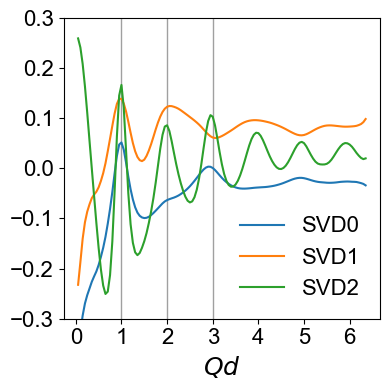

In [138]:
fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot()
ax.plot([1,1],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot([2,2],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot([3,3],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot(qq[1:]/20/np.pi,-Vh[0], label='SVD0')
ax.plot(qq[1:]/20/np.pi,-Vh[1], label='SVD1')
ax.plot(qq[1:]/20/np.pi,Vh[2], label='SVD2')


ax.set_xticks(np.arange(0,7))
ax.set_xlabel(r'$Qd$',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16,framealpha=0,loc='lower right')

ax.set_ylim(-0.3,0.3)

plt.tight_layout()
plt.show()

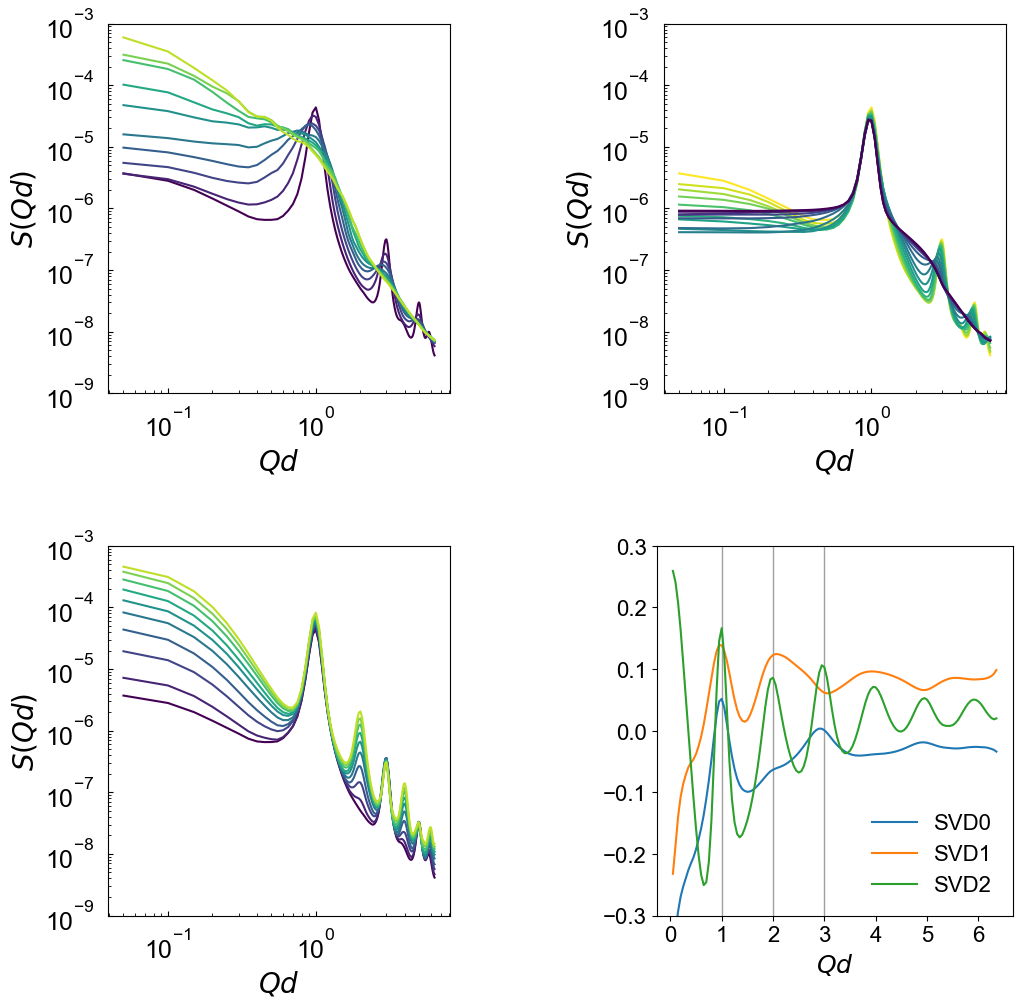

In [199]:
## plot results: varying k_z
fig = plt.figure(figsize=(12,11))
ax = fig.add_subplot(2,2,1)

for i, k_z_i in enumerate(set_k_z):
    parameters = [k_z_i,set_alpha[0],set_kappa[0]]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(i/10)

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.4)

ax = fig.add_subplot(2,2,2)

for i, kappa_i in enumerate(set_kappa[:15]):
    parameters = [set_k_z[0],set_alpha[0],kappa_i]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(np.log(kappa_i)/np.log(128))  

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.4)

ax = fig.add_subplot(2,2,3)

for i, alpha_i in enumerate(set_alpha):
    parameters = [set_k_z[0],alpha_i,set_kappa[0]]
    index = id_params(parameters)
    
    color = color_params(parameters)
    color = plt.cm.viridis(i/10)

    ax.plot(qq[1:]/20/np.pi,S_q_sm_Grid[index,],'-',color=color)

ax.set_xlabel(r'$Qd$',fontsize=20)
ax.set_ylabel(r'$S(Qd)$',fontsize=20)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_xlim([0,100])
ax.set_ylim([1e-9,1e-3])
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.set_aspect(1/2.4)

ax = fig.add_subplot(2,2,4)
ax.plot([1,1],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot([2,2],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot([3,3],[-0.3,0.3],'-',color='#A0A0A0',lw=1)
ax.plot(qq[1:]/20/np.pi,-Vh[0], label='SVD0')
ax.plot(qq[1:]/20/np.pi,-Vh[1], label='SVD1')
ax.plot(qq[1:]/20/np.pi,Vh[2], label='SVD2')


ax.set_xticks(np.arange(0,7))
ax.set_xlabel(r'$Qd$',fontsize=18)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.legend(fontsize=16,framealpha=0,loc='lower right')

ax.set_ylim(-0.3,0.3)
ax.set_aspect(12)

plt.tight_layout(pad=4)
plt.show()

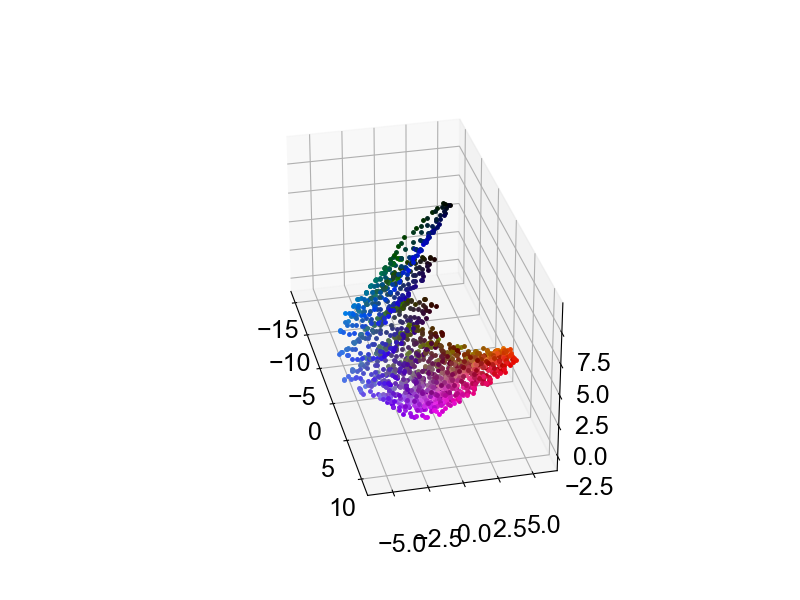

In [80]:
%matplotlib widget 
# %matplotlib inline 
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1,projection='3d')

for i, parameters in enumerate(p_Grid[kappa>=1,:]):    
    color = color_params(parameters)*np.array([1,1,1])

    ax.plot(FV[i,0],FV[i,1],FV[i,2],'.',ms=5,c=color) 
    ax.set_aspect('equal')

ax.view_init(elev=30, azim=-13)

# ax.set_xlabel('SVD0',fontsize=20)
# ax.set_ylabel('SVD1',fontsize=20)
# ax.set_zlabel('SVD2',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)

# plt.tight_layout()
plt.show()

C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\3424396773.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)
C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\3424396773.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,1,2,3,4,5],fontsize=14)
C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\3424396773.py:42: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)


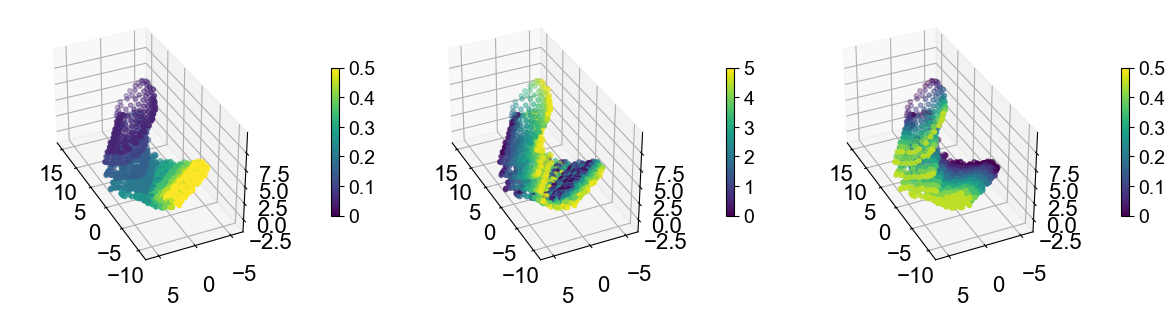

In [173]:
# %matplotlib widget 
%matplotlib inline 
fig = plt.figure(figsize=(12,4))
## k_z
ax = fig.add_subplot(1,3,1,projection='3d')

panel_k_z = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=p_Grid_SVD[:,0]/20,marker='.',vmin=0,vmax=0.5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_k_z, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

## kappa
ax = fig.add_subplot(1,3,2,projection='3d')

panel_kappa = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=np.log(p_Grid_SVD[:,2]),marker='.',vmin=0,vmax=5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_kappa, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,1,2,3,4,5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

## alpha
ax = fig.add_subplot(1,3,3,projection='3d')

panel_alpha = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=p_Grid_SVD[:,1],marker='.',vmin=0,vmax=0.5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_alpha, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

plt.tight_layout()
plt.show()

C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\4046376671.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)
C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\4046376671.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,1,2,3,4,5],fontsize=14)
C:\Users\CHTUNG\AppData\Local\Temp\ipykernel_14768\4046376671.py:46: UserWarning: FixedFormatter should only be used together with FixedLocator
  colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)


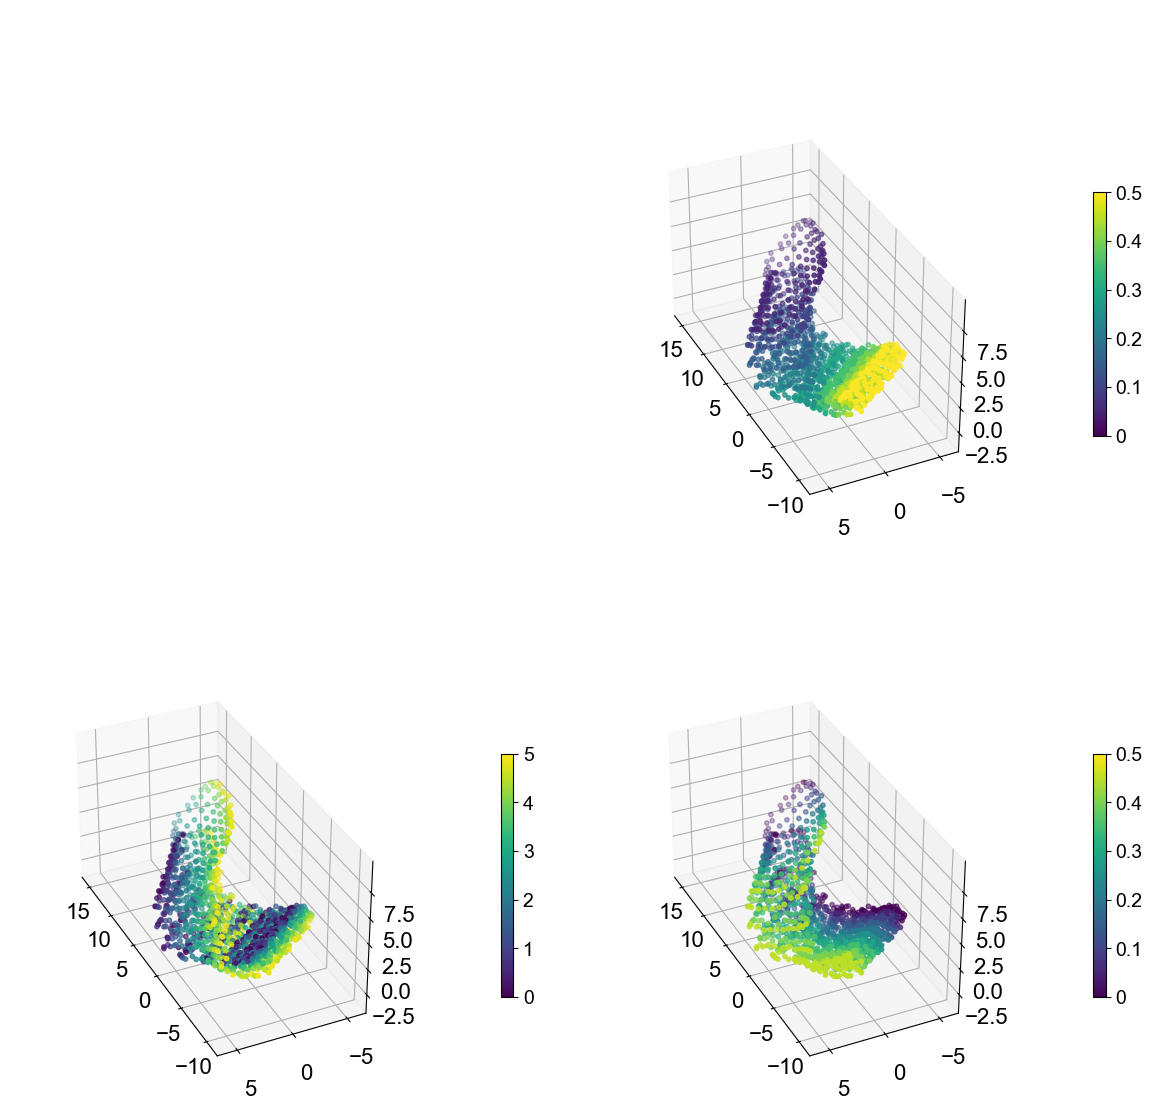

In [129]:
# %matplotlib widget 
%matplotlib inline 
fig = plt.figure(figsize=(12,12))
## basis
ax = fig.add_subplot(2,2,1)
ax.axis('off')

## k_z
ax = fig.add_subplot(2,2,2,projection='3d')

panel_k_z = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=p_Grid_SVD[:,0]/20,marker='.',vmin=0,vmax=0.5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_k_z, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

## kappa
ax = fig.add_subplot(2,2,3,projection='3d')

panel_kappa = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=np.log(p_Grid_SVD[:,2]),marker='.',vmin=0,vmax=5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_kappa, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,1,2,3,4,5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

## alpha
ax = fig.add_subplot(2,2,4,projection='3d')

panel_alpha = ax.scatter(-FV[:,0],-FV[:,1],FV[:,2],s=40,c=p_Grid_SVD[:,1],marker='.',vmin=0,vmax=0.5)

ax.set_aspect('equal')
ax.view_init(elev=33, azim=155)
colorbar = plt.colorbar(panel_alpha, shrink=0.4, pad=0.15)
colorbar.ax.set_yticklabels([0,0.1,0.2,0.3,0.4,0.5],fontsize=14)

ax.tick_params(direction='in', axis='both', which='both', labelsize=16, pad=5)
ax.set_xticks([-10,-5,0,5,10,15])
ax.set_yticks([-5,0,5])
ax.set_zticks([-2.5,0,2.5,5,7.5])

plt.tight_layout()
plt.show()